<a href="https://colab.research.google.com/github/yudianke/online-payment-fraud-detection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Online Payments Fraud Detection**

### **Problem Definition**

**The Context**:

Online payments have become the backbone of modern financial transactions. However, with the convenience comes the risk of fraud. Fraudulent activities can lead to significant financial losses for both customers and financial institutions, damaging trust and reputation.

* **Why is this important?** Detecting fraud in real-time allows institutions to block malicious transactions, saving millions in potential losses and maintaining customer trust.

**The Objective**:

The primary goal is to develop a machine learning model that can accurately predict whether a transaction is fraudulent (`isFraud = 1`) or legitimate (`isFraud = 0`). We need to maximize the identification of fraud cases (Recall) while minimizing false alarms that block legitimate users (Precision).

**Key Questions**:

* What are the distinct patterns associated with fraudulent transactions?

* Which transaction types are most susceptible to fraud?

* Can we build a model that outperforms a simple rules-based approach?

**About the Dataset**

The Online Payments Fraud Detection Dataset is a synthetic transaction dataset with ~6.3M transactions and 11 features. The below column reference:

* step: represents a unit of time where 1 step equals 1 hour
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction


**Target Variable**: `isFraud`

**Success Metric**: We prioritize **Recall** for the Fraud class (Class 1) because missing a fraudulent transaction (False Negative) is much more costly than flagging a legitimate one (False Positive).

### **Import Libraries**

In [21]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

### **Data Overview**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Upload file to google drive and use project directory accordingly
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/payments.csv")

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [6]:
df.shape

(6362620, 11)

* As mentioned in the Data Dictionary, the DataFrame has **11** columns and a total of **6362620** rows (that's a lot of data!). Each row contains detailed information about a specific transaction, capturing its status, type, amount, and the balances of both the initiating and receiving accounts at the time the transaction occurred.

* There are some transactions where the old balance (`oldbalanceOrg`) contains money, but the new balance (`newbalanceOrg`), which could be an indicator of fraud.



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


* The Dataframe has a total of **5** columns of **float64** datatype, **3** columns of **int64** datatypes, and **2** columns of **object** datatypes.

In [8]:
df.nunique()

,0
step,743
type,5
amount,5316900
nameOrig,6353307
oldbalanceOrg,1845844
newbalanceOrig,2682586
nameDest,2722362
oldbalanceDest,3614697
newbalanceDest,3555499
isFraud,2


* Each step represents one hour, so the data covers a period of approximately 743 hours, which is roughly 30 to 31 days.

* `isFraud` and `isFlaggedFraud` only contain two unique values (0 and 1).

* The data contains only five distinct types of transactions (`CASH-IN`, `CASH-OUT`, `TRANSFER`, `PAYMENT`, DEBIT`). This can be used as a categorical variable for modeling.

* `nameOrig` has 6353307 unique values, meaning almost every transaction was initiated by a unique individual or was a first-time transaction from that account.

In [9]:
duplicate = df.duplicated().sum()
print("Duplicate Rows :", duplicate)

Duplicate Rows : 0


* There are **no duplicate rows**, meaning every entry originates from a unique transaction.

In [10]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


* **No columns have null values**, including our target variable (`isFraud`), which is very beneficial when creating the model.

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


* A notable observation is that the median (50%) for `newbalanceOrig` is `$0.00`. This suggests that half of the accounts that initiate a transaction end up with a zero balance after the transaction completes.

* The mean values are significantly higher than the median (50% value) for almost all balance and amount columns. For example, the maximum for `amount` is over `$92 million`, while the 50th percentile is only `~$75000`. This indicates extreme outliers are present.



Fraud Distribution:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64


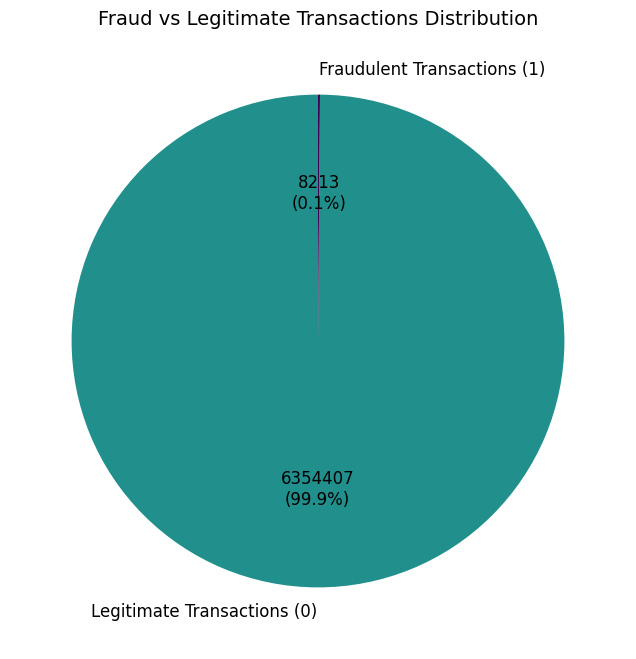

In [12]:
# Check Class Imbalance
fraud_counts = df['isFraud'].value_counts()
print("\nFraud Distribution:\n", fraud_counts)
labels = ['Legitimate Transactions (0)', 'Fraudulent Transactions (1)']

def absolute_and_percentage_format(pct):
    # Calculate the absolute count from the percentage
    absolute_count = int(round(pct/100.*fraud_counts.sum()))
    return f"{absolute_count}\n({pct:.1f}%)"

plt.figure(figsize=(8, 8))
plt.pie(
    fraud_counts,
    labels=labels,
    autopct=absolute_and_percentage_format,
    startangle=90, # Start the first slice at 90 degrees
    colors=['#21908d', '#440154'],
    textprops={'fontsize': 12}
)
plt.title('Fraud vs Legitimate Transactions Distribution', fontsize=14)
plt.show()

* Out of over 6 million transactions, only **8213** get flagged as fradulent, which is **0.1%** of the dataset. This demonstrates a significant imbalance between legitimate and fraudulent transactions, with legitimate transactions being vastly more common.

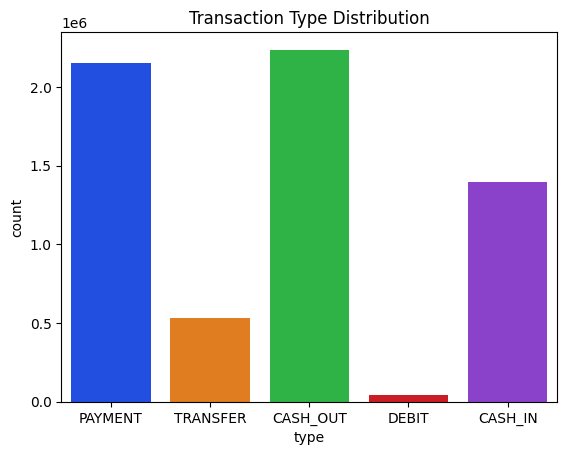

In [13]:
sns.countplot(x='type', data=df, hue='type', palette='bright', dodge=False)
plt.title('Transaction Type Distribution')
plt.show()

* The most frequent transaction types are `CASH_OUT` and `PAYMENT`, each accounting for over 2 million transactions.

* `DEBIT` transactions are extremely rare, barely visible on the chart and having a count close to zero.

* `TRANSFER` transactions are also relatively low in frequency, with approximately 500,000 instances, while `CASH_IN` transactions occur roughly 1.4 million times.

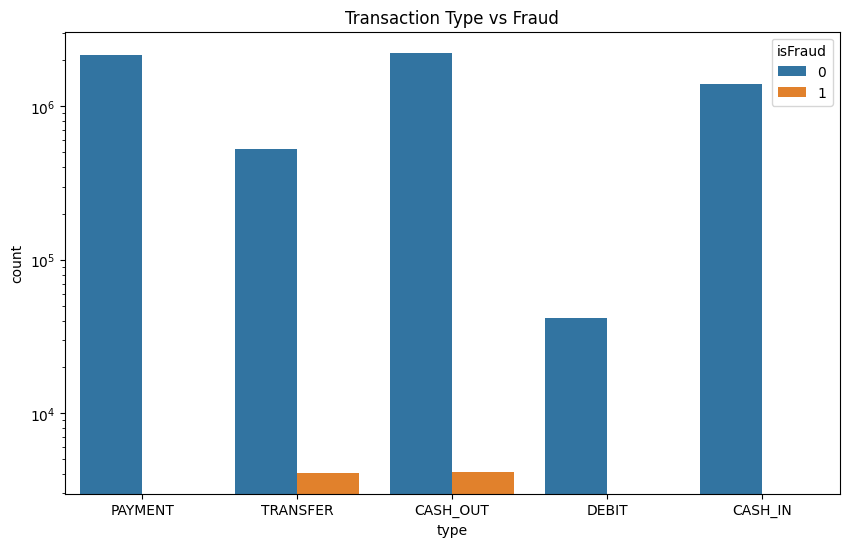

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


In [14]:
# Fraud by Transaction Type
plt.figure(figsize=(10, 6))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Transaction Type vs Fraud')
plt.yscale('log') # Log scale to make small fraud counts visible
plt.show()

# Print exact counts
print(df.groupby('type')['isFraud'].sum())

* Fraudulent transactions are exclusively present in the `TRANSFER` and `CASH_OUT` transaction types. There are virtually no fraudulent transactions recorded for `PAYMENT`, `DEBIT`, or `CASH_IN` types. This is a crucial finding for feature engineering.

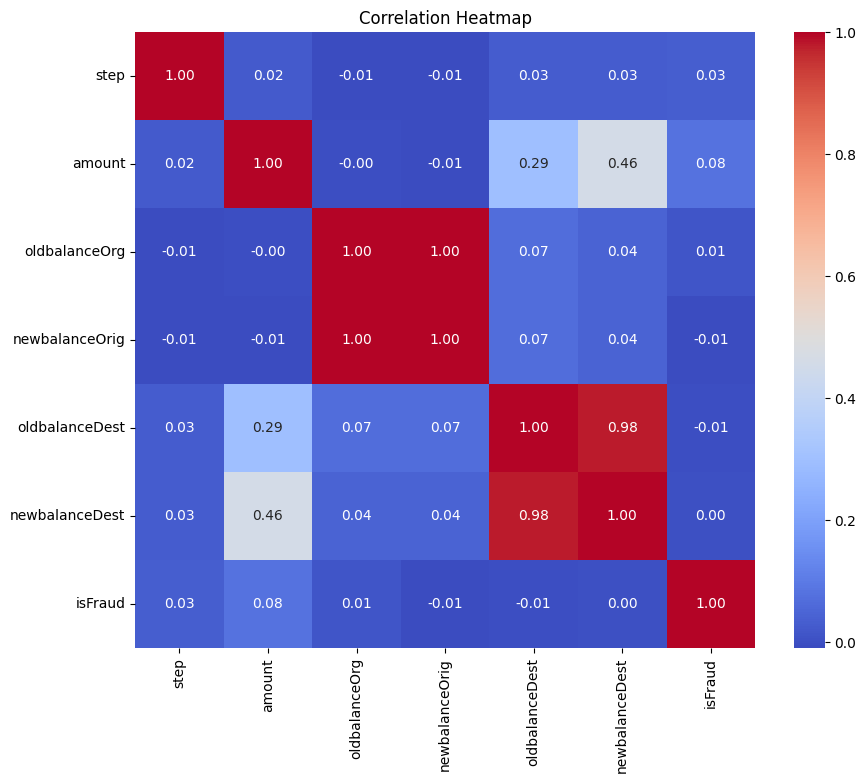

In [15]:
# Filter data to only relevant types for correlation
numeric_df = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']]
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

* There is a perfect positive correlation (1.00) between `oldbalanceOrg` and `newbalanceOrig`, and `oldbalanceDest` and `newbalanceDest`. This indicates that the balance changes are consistent with transaction amounts/

* `amount` has a moderate positive correlation with `oldbalanceDest` (0.29) and `newbalanceDest` (0.46).

* The `isFraud` target variable shows very weak correlations (close to zero) with all other features, with the highest being 0.08 with `amount`. This suggests linear correlation is not a strong indicator for fraud prediction in this dataset.

### **Data Preprocessing**

Based on the exploratory data analysis, we can do the following preprocessing steps:

**Filter Data**

Since fraudulent transactions appear in `TRANSFER` and `CASH_OUT` only, we can filter these columns for review.

In [16]:
# Keep only TRANSFER and CASH_OUT
df_filtered = df.loc[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

**Feature Engineering**

Fraudsters often empty accounts. So, we can create a feature to capture deviations from this. The new column `errorBalanceOrig` and `errorBalanceDest` is made using this calculation logic: `new_balance = old_balance - amount`

In [17]:
# Create new feature Error in Balance
df_filtered['errorBalanceOrig'] = df_filtered['newbalanceOrig'] + df_filtered['amount'] - df_filtered['oldbalanceOrg']
df_filtered['errorBalanceDest'] = df_filtered['oldbalanceDest'] + df_filtered['amount'] - df_filtered['newbalanceDest']

**Dropping Irrelevant Columns**

`nameOrig` and `nameDest` are strings with too many unique values. Also, `isFlaggedFraud` is redundant since we already have `isFraud` as the target variable with the same purpose. Therefore, we can drop these columns.

In [18]:

# Drop Irrelevant Columns
df_filtered = df_filtered.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

**Label Encoding**

We can label encode column `type` (now containing only `TRANSFER` and `CASH_OUT`).

In [22]:

# Label Encode 'type' (TRANSFER=0, CASH_OUT=1 or vice versa)
le = LabelEncoder()
df_filtered['type'] = le.fit_transform(df_filtered['type'])

# We can use this for label encoding too
#df = pd.get_dummies(df, columns=['type'], drop_first=True)

**Define Target Variables**

In [23]:
# Define X and y
X = df_filtered.drop('isFraud', axis=1)
y = df_filtered['isFraud']

**Train-Test Split**

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Scaling the Data**

We use RobustScaler because the financial data has massive outliers.

In [25]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Apply SMOTE (Synthetic Minority Over-sampling Technique)**

To take care of the class imbalance situation, we apply SMOTE to generate points for the minority class.

In [26]:
# Handling Imbalance using SMOTE (only the training set)
print("Before SMOTE, counts of label '1': {}".format(sum(y_train == 1)))
print("Before SMOTE, counts of label '0': {}".format(sum(y_train == 0)))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE, counts of label '1': {}".format(sum(y_train_resampled == 1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_train_resampled == 0)))

Before SMOTE, counts of label '1': 6570
Before SMOTE, counts of label '0': 2209757
After SMOTE, counts of label '1': 2209757
After SMOTE, counts of label '0': 2209757


### **Model Building**

The `model_performance_classification` prints a classification report containig the following metrics for each class:

* **Precision**: The proportion of positive identifications that were actually correct.
* **Recall**: The proportion of actual positives that were identified correctly.
* **F1-Score**: The harmonic mean of precision and recall.
* **Support**: The number of actual occurrences of each class in the specified dataset

The **Receiver Operating Characteristic** (**ROC**) curves and the **Area Under the Curve** (**AUC**) metric are calculated, which helps visualize the trade-off between catching fraud (True Positive Rate) and incorrectly flagging legitimate transactions (False Positive Rate).

In [32]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance
    """
    pred = model.predict(predictors)

    # Confusion Matrix
    cm = confusion_matrix(target, pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(target, pred))

    # ROC-AUC
    try:
        probs = model.predict_proba(predictors)[:, 1]
        print(f"ROC-AUC Score: {roc_auc_score(target, probs):.4f}")
    except:
        pass

#### Logistic Regression


Model 1: Logistic Regression


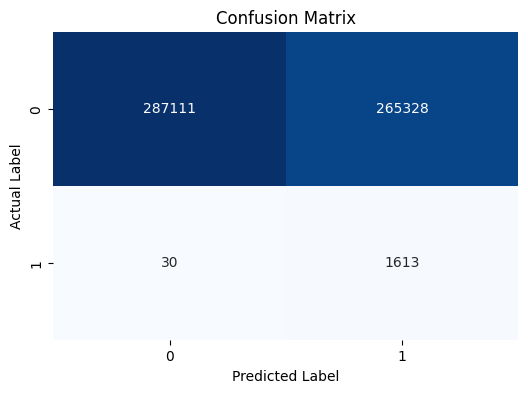

              precision    recall  f1-score   support

           0       1.00      0.52      0.68    552439
           1       0.01      0.98      0.01      1643

    accuracy                           0.52    554082
   macro avg       0.50      0.75      0.35    554082
weighted avg       1.00      0.52      0.68    554082

ROC-AUC Score: 0.9453


In [28]:
# --- Model 1: Logistic Regression ---
print("\n" + "="*30)
print("Model 1: Logistic Regression")
print("="*30)

# Create logistic regression model object
lr = LogisticRegression(random_state=42, solver='liblinear')

# Fit model
lr.fit(X_train_resampled, y_train_resampled)

# Predict on scaled test data
model_performance_classification(lr, X_test_scaled, y_test)

* Recall for Class 1 (fraud) is **0.98**, meaning the model successfully identifies 98% of the actual fraud cases. Alternatively, the precision for class 0 (legitimate) is **1.00**, meaning when the model predicts a legitimate transaction, it is almost always correct.

* However, recall for class 0 is **0.52** and precision for class 1 is **0.01**. This means the model misses almost half (48%) of the actual legitimate cases, incorrectly classifying them as fraud. When the model predicts fraud, it is almost certainly a false alarm (a legitimate user being incorrectly flagged). This maximizes false alarms where our objectvive is to minimize them.

* The ROC-AUC Score (**0.9453**) indicates that the model has a good ability to distinguish between the classes.

#### Random Forest


Model 2: Random Forest Classifier


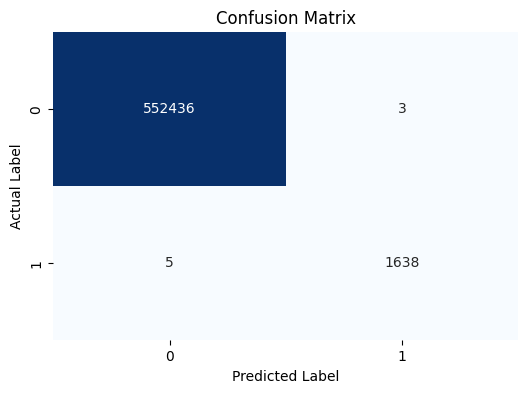

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       1.00      1.00      1.00      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

ROC-AUC Score: 0.9995


In [29]:
# --- Model 2: Random Forest Classifier ---
print("\n" + "="*30)
print("Model 2: Random Forest Classifier")
print("="*30)

# Limiting depth to prevent overfitting on the synthetic data
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Fit model
rf.fit(X_train_resampled, y_train_resampled)

# Predict on scaled test data
model_performance_classification(rf, X_test_scaled, y_test)

* For classes 0 and 1, the model has perfect precision (**1.00**) for both classes. A prediction of fraud is always correct, and a prediction of a legitimate user is always correct.

* The model also has perfect recall (**1.00**) for both classes. It misses no legitimate users and misses no actual fraud cases.

* The ROC-AUC Score (**0.9995**) confirms the exceptional ability of the model to separate the two classes.

**Feature Importance**

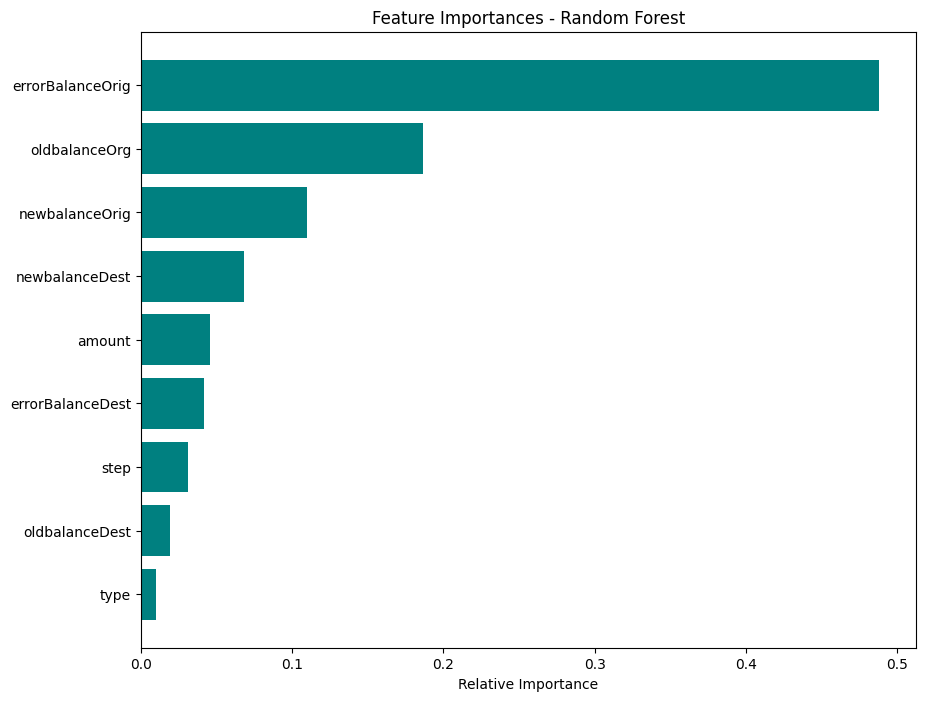

In [30]:
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X.columns

plt.figure(figsize=(10, 8))
plt.title('Feature Importances - Random Forest')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**ROC-AUC Comparison**

The ROC curve plots True Positive Rate (catching fraud) vs. False Positive Rate (incorrectly flagging legitimate transactions) across different thresholds, and the AUC summarizes this performance, indicating how well the model separates classes. If AUC = 1.0, it is a perfect model that perfectly separates classes. If AUC > 0.5, the model has some ability to discriminate between classes. If AUC ≤ 0.5, the model performs no better than random chance.


Model Comparison: ROC Curves


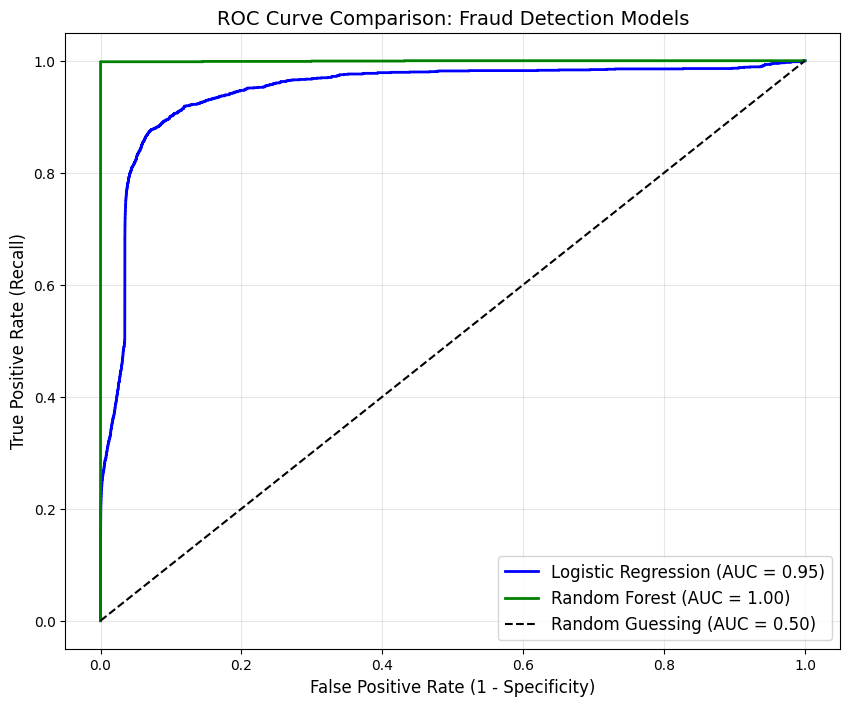

In [31]:
print("\n" + "="*30)
print("Model Comparison: ROC Curves")
print("="*30)

# Predict probability of the positive class (Class 1 - Fraud), which is at index 1
y_prob_log = lr.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Calculate AUC Scores
auc_log = roc_auc_score(y_test, y_prob_log)
auc_rf = roc_auc_score(y_test, y_prob_rf)

# Calculate ROC Curve Metrics (False Positive Rate, True Positive Rate)
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)


plt.figure(figsize=(10, 8))

# Plot Logistic Regression Curve
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.2f})', color='blue', linewidth=2)

# Plot Random Forest Curve
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='green', linewidth=2)

# Plot Diagonal (Random Guessing Line)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve Comparison: Fraud Detection Models', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

* The diagonal dashed line represents a model that performs no better than random chance (AUC = 0.50).

* The **Random Forest** model (Green Line) has **AUC = 1.00**. The curve follows the left and top axes, meaning the model can achieve a 1.0 true positive rate (identifying all fraud cases) with a 0.0 false positive rate (no false alarms).

* The **Logistic Regression** model (Blue Line) has a high **AUC = 0.95**, which is also very good. However, compared to the Random Forest, its curve is lower, indicating it is not as effective at distinguishing between the two classes.  

### **Results**

**Meaningful Insights**:

* **Best Model**:

* **Critical Predictors**:

* **Transaction Types**:

### **Conclusion**

**Recommendations to Prevent Fraud**: